In [1]:
from os.path import exists 
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


task = "cyp1a2"

# Data

In [2]:
# load thedataset
data = data_preprocessing(task)
# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)
data = select_druglike_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

data

Dataset already exists, returning data/cyp1a2/raw_dataset.csv.
Number of molecules before druglikeliness selection: 12579
Number of druglike molecules: 12138


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,644510.0,13.221898,-0.305076,13.221898,0.022394,0.383547,466.473,443.289,...,0,0,0,0,0,0,0,0,0,0
2,1,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1960010.0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,...,0,0,0,0,0,0,1,0,0,0
3,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
4,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12574,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
12575,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12576,0,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12577,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


### Remove missing values 
Since less than 1% of molecules have missing values we simply remove those molecules since using a default value doesn't make much sense for the shown descriptors.

In [3]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data = data.drop(data_nan.index)
print("Data shape after dropping NaN samples:", data.shape)
data_nan

There are 37 (0.30%) molecules and 12 descriptors with missing values.
Data shape after dropping NaN samples: (12101, 2260)


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3783,O=[N+]([O-])c1ccc(C[As](=O)(O)O)cc1,222574.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807,C[C@@H](O)COc1ccc([As](=O)(O)O)cc1N,3246035.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3814,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3815,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3816,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3817,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818,O=[As]c1ccc(S(=O)(=O)NCCO)cc1,224336.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3823,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3834,O=[As](O)(O)c1ccc(N=Nc2ccc([As](=O)(O)O)cc2)cc1,23749.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3835,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train-Validation-Test split


In [4]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('float64'), dtype('int64')}


,Y,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
count,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,...,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000,8470.000000
mean,0.477568,11.142495,-0.806560,11.142495,0.206695,0.636130,339.219046,319.861043,338.846665,125.132231,...,0.015230,0.003896,0.015584,0.008855,0.024085,0.009563,0.013932,0.006257,0.011806,0.003896
std,0.499526,2.737934,1.425193,2.737934,0.235065,0.170997,84.501805,80.294780,84.398197,31.624572,...,0.122475,0.062301,0.123868,0.093688,0.153322,0.097328,0.117214,0.078860,0.108020,0.062301
min,0.000000,0.000000,-7.117338,0.000000,0.000000,0.086171,17.031000,14.007000,17.026549,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.824511,-0.957935,10.824511,0.049059,0.512421,284.294750,268.184000,284.081904,104.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,12.179280,-0.369183,12.179280,0.127619,0.654461,338.365500,319.224500,338.058883,124.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,12.827624,-0.028584,12.827624,0.257808,0.778273,394.427500,372.323000,394.056805,146.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,17.219465,1.750000,17.219465,3.811700,0.946895,772.856000,724.472000,772.343192,298.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


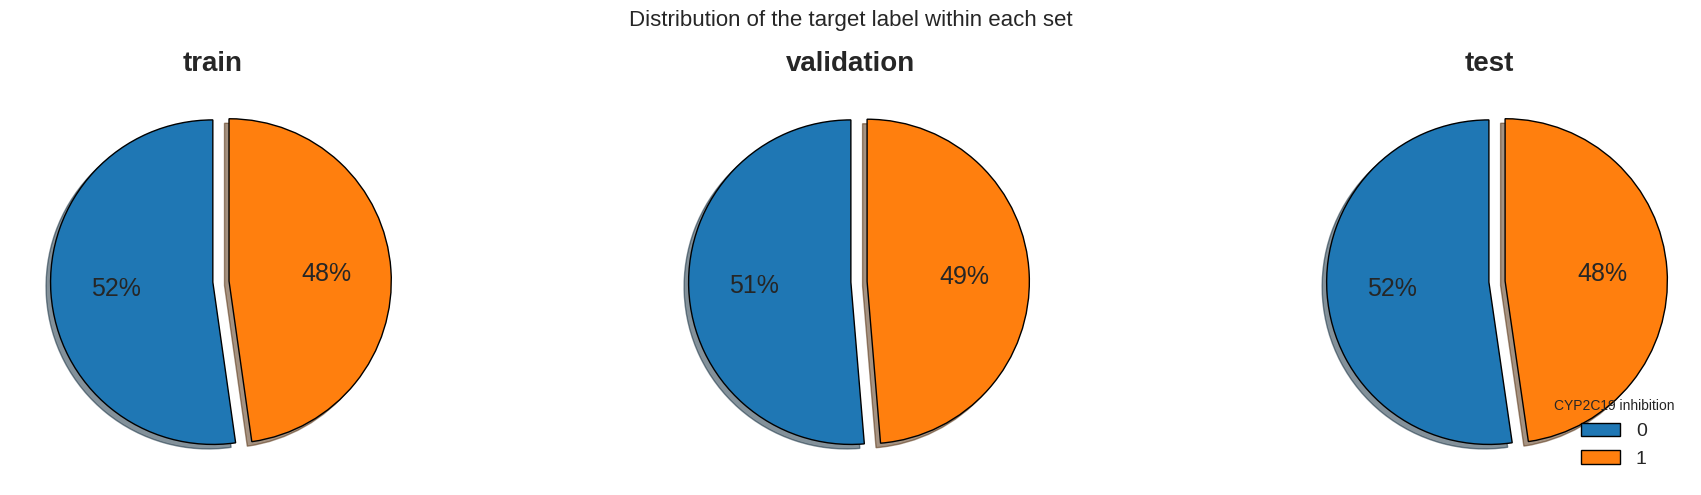

In [5]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie"
)
datasets["train"].describe()

# Training

Use ```utils/training/BayesianOptimizer```. To do random search simply set ```n_calls=n_initial_points``` in ```self.optimize()```.

## Dummy Classifier

Accuracy: 51.32%
F1-score: 0.00%
Matthews correlation coefficient: 0.0%


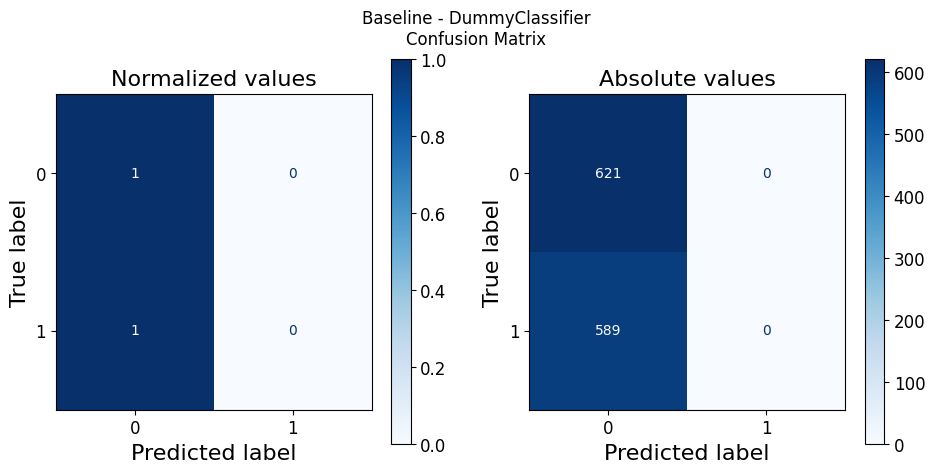

In [6]:
get_baseline(datasets)

## SVC

In [7]:
svc_0 = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    fix_model_params={"class_weight": "balanced"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc"
)

svc_0.optimize(n_calls=20) 
svc_0.pretty_results()

,C,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc
19,2.497002,0.048463,0.001644,0.003149,0.957488,0.866942,0.865272,0.853135,0.877759,0.734186
18,3.003243,0.045939,0.009008,0.001890,0.999843,0.866116,0.864322,0.852893,0.876061,0.732488
16,3.217315,0.045563,0.004249,0.003625,0.967535,0.865289,0.863826,0.850329,0.877759,0.730974
17,3.190175,0.038988,0.007924,0.002472,0.917302,0.863636,0.861925,0.849835,0.874363,0.727572
4,3.329981,0.021216,0.007910,0.001814,0.818837,0.861983,0.860251,0.848185,0.872666,0.724265


Number of features after preprocessing:             1898/2256
Accuracy: 86.69%
F1-score: 86.53%
Matthews correlation coefficient: 0.7341858047546367%


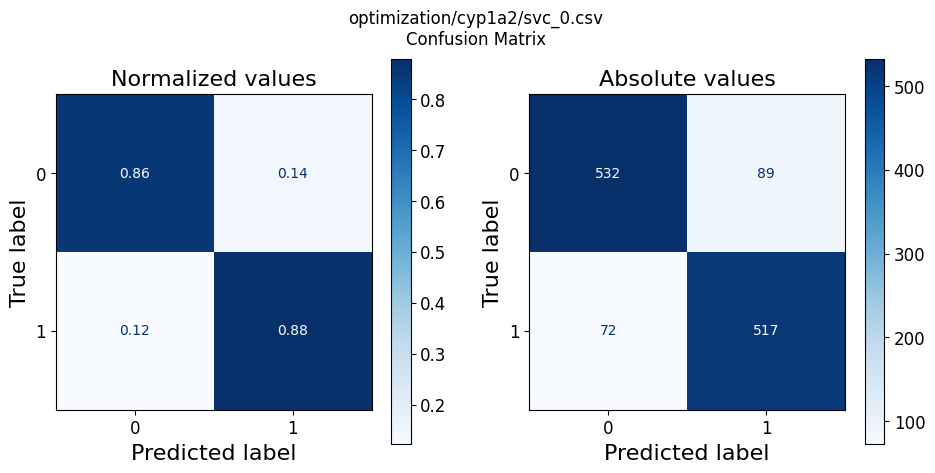

In [8]:
metric_columns = list(svc_0.results.filter(regex='val_'))
# Position 0
best_params_0 = svc_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
svc_0_y_pred, svc_0_y_pred_proba = svc_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], svc_0_y_pred, svc_0.file_loc)

del svc_0

## RandomForestClassifier

For a random forest classifier we don't need to do any preprocessing. A decision tree based classifier is scale invariant and has inbuild feature selection.

In [9]:
x_train = datasets["train"].drop("Y", axis=1)
y_train = datasets["train"]["Y"]
x_val = datasets["val"].drop("Y", axis=1)
y_val = datasets["val"]["Y"]

# drop constant features
preprocessing_pipe = DataPreprocessing(feature_groups, corr_threshold=1.0)
preprocessing_pipe.fit(x_train, y_train)
x_train_preprocessed = preprocessing_pipe.transform(x_train)
x_val_preprocessed = preprocessing_pipe.transform(x_val)

rf_max_depth = train_random_forest_depth(
    f"optimization/{task}/rf_max_depth",
    x_train_preprocessed,
    x_val_preprocessed,
    y_train,
    y_val,
    class_weight="balanced"
)

metric_columns = list(rf_max_depth.filter(regex="val_"))

pretty_print_df(
    rf_max_depth.sort_values("val_mcc", ascending=False), subset=metric_columns, quantile=0.98
)

,max_depth,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
43,46,0.857025,0.849172,0.872760,0.826825,0.714403,0.934649,0.931372
45,48,0.857025,0.849696,0.870107,0.830221,0.714225,0.934686,0.932360
42,45,0.855372,0.845543,0.880515,0.813243,0.711953,0.932677,0.932730
54,57,0.854545,0.848014,0.862917,0.833616,0.709021,0.933581,0.932198
33,36,0.853719,0.844053,0.877289,0.813243,0.708483,0.931038,0.930824


In [ ]:
best_depth = int(rf_max_depth.sort_values("val_mcc", ascending=False).iloc[0]["max_depth"])
best_rf = RandomForestClassifier(max_depth = best_depth, class_weight="balanced", n_jobs=-1)
best_rf.fit(x_train_preprocessed, y_train)
rf_best_y_pred = best_rf.predict(x_val_preprocessed)
rf_best_y_pred_proba = best_rf.predict_proba(x_val_preprocessed)[:,1]

conf_matrix(y_val, rf_best_y_pred, f"RandomForestClassifier(max_depth={best_depth})")

In [ ]:
compare_metric_curves(
    {
        "RandomForestClassifier": rf_best_y_pred_proba
    },
    datasets["val"]["Y"],
)

## Logistic Regression

In [ ]:
lr_0 = BayesianOptimization(
    model=LogisticRegression,
    file_name=f"{task}/lr_0",
    model_params=[
        Real(name="C", low=0.1, high=4.0),
        Real(name="l1_ratio", low=0, high=1),
    ],
    fix_model_params={
        "solver": "saga",
        "n_jobs": -1,
        "class_weight": "balanced",
        "penalty": "elasticnet",
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

lr_0.optimize(n_calls=20)
lr_0.pretty_results()

In [ ]:
metric_columns = list(lr_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = lr_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
lr_0_best_y_pred, lr_0_best_y_pred_proba = lr_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], lr_0_best_y_pred, lr_0.file_loc)

del lr_0 

## CatBoost


In [ ]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

catboost_0 = BayesianOptimization(
    model=CatBoostClassifier,
    file_name=f"{task}/catboost_0",
    model_params=[
        Integer(name="max_depth", low=4, high=12),
        Real(name="l2_leaf_reg", low=2., high=10.),
        # Categorical(name="boosting_type", categories=["Ordered", "Plain"]),
        Real(name="scale_pos_weight",low=max(1,n_negative/n_positive-1), high=6),
    ],
    fix_model_params={
        "verbose": 0,
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

catboost_0.optimize(n_calls=50)
catboost_0.pretty_results(quantile=0.9)

In [ ]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

## KNN

In [ ]:
knn_0 = BayesianOptimization(
    model=KNeighborsClassifier,
    file_name=f"{task}/knn_0", 
    model_params=[
        Integer(name="n_neighbors", low=3, high=60),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=None,
    main_metric="mcc",
    fix_model_params={"weights":"distance"}
)

knn_0.optimize(n_calls=20)
knn_0.pretty_results()

In [ ]:
metric_columns = list(knn_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)

best_params_0 = list(knn_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
knn_0_best_y_pred, knn_0_best_y_pred_proba = knn_0.get_predictions(best_params_0)
conf_matrix(datasets["val"]["Y"], knn_0_best_y_pred, knn_0.file_loc)

del knn_0

## XGBoost

In [12]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

xgboost_0 = BayesianOptimization(
    model=XGBClassifier,
    file_name=f"{task}/xgboost_",
    model_params=[
        Integer(name="max_depth", low=5, high=50),
        Real(name="eta", low=0.01, high=0.2),
        Real(name="subsample", low=0.5, high=1),
        Real(name="scale_pos_weight", low=max(1, n_negative / n_positive - 1), high=6),
        Real(name="colsample_bytree", low=0.5, high=1.0),
        Real(name="lambda", low=0.5, high=4.0),
    ],
    fix_model_params={"objective": "binary:logistic", "eval_metric": "aucpr"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

xgboost_0.optimize(n_calls=70)
xgboost_0.pretty_results()

,max_depth,eta,subsample,scale_pos_weight,colsample_bytree,lambda,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
8,43,0.147094,0.846458,4.304004,0.905882,1.107695,0.035264,0.043667,0.008435,0.979899,0.861983,0.862777,0.835987,0.891341,0.725751,0.940255,0.939593
56,46,0.157573,0.842674,4.398773,0.667249,2.364076,0.036406,0.041927,0.000642,0.968642,0.859504,0.861564,0.827856,0.898132,0.721887,0.941709,0.943014
55,47,0.136325,0.795932,2.931153,0.913211,1.640904,0.032101,0.047130,0.009652,0.984075,0.860331,0.860215,0.838710,0.882852,0.721791,0.940821,0.940456
65,21,0.171872,0.836373,3.432091,0.662011,1.090815,0.031046,0.047429,0.009169,0.986006,0.858678,0.857619,0.841503,0.874363,0.717961,0.941250,0.941465
45,19,0.176383,0.890229,3.908913,0.582640,2.163737,0.026188,0.043649,0.009052,0.924609,0.857851,0.858320,0.833600,0.884550,0.717219,0.937934,0.937762


Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
Number of features after preprocessing:             2185/2256
Accuracy: 85.70%
F1-score: 85.88%
Matthews correlation coefficient: 0.716596327302568%


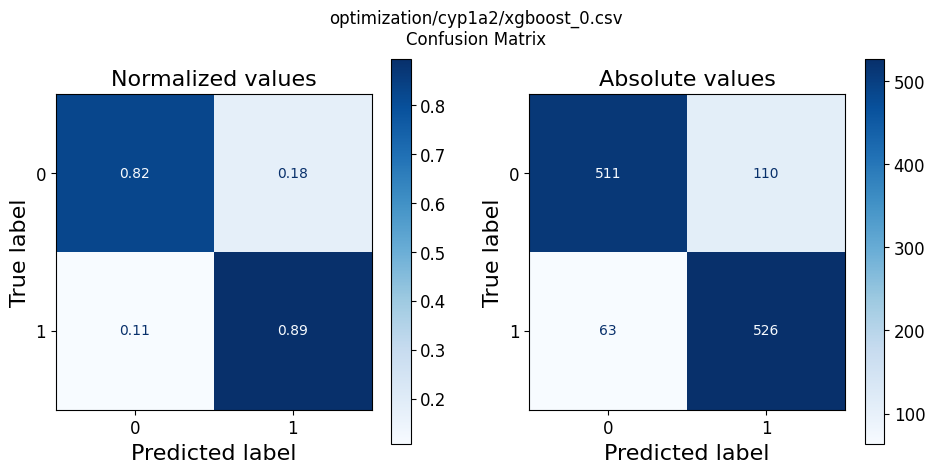

In [13]:
metric_columns = list(xgboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = list(xgboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
xgboost_0_best_y_pred, xgboost_0_best_y_pred_proba = xgboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], xgboost_0_best_y_pred, xgboost_0.file_loc)

del xgboost_0

In [ ]:
compare_metric_curves(
    {
        "XGBoost" : xgboost_0_best_y_pred_proba
    },
    datasets["val"]["Y"],
)